# Tensorflow

In [1]:
# In case of multiple GPUs we only use number 1, otherwise we block all of them
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
np.set_printoptions(precision=2, suppress=True)

import collections

class TensorflowGraphToDot:
    def __init__(self, op, suppressed_nodes = ['gradients']):
        from graphviz import Digraph
        self.dot = Digraph()
        self.nodes = collections.OrderedDict()
        import tensorflow.contrib.graph_editor as ge
        for node in ge.get_backward_walk_ops(op):
            self.nodes[node.node_def.name] = node.node_def.input
        self.suppressed_nodes = suppressed_nodes
        for node_name in self.nodes:
            self.draw_node(node_name)
            for input_node in self.nodes[node_name]:
                self.draw_edge(input_node, node_name)
            
    def is_suppressed(self, node_name):
        return any([s in node_name for s in self.suppressed_nodes])

    def draw_edge(self, from_node_name, to_node_name):
        if self.is_suppressed(from_node_name):
            if from_node_name in self.nodes:
                for next_node_name in self.nodes[from_node_name]:
                    self.draw_edge(next_node_name, to_node_name)
        else:
            if not self.is_suppressed(to_node_name):
                self.dot.edge(from_node_name, to_node_name)

    def draw_node(self, node_name):
        if not self.is_suppressed(node_name):       
            self.dot.node(node_name, label=node_name)
            
    def _repr_svg_(self):
        return self.dot._repr_svg_()

class NumpyToLatex:
    def __init__(self, expression, dictionary=None):
        if dictionary is None:
            dictionary = globals()
        latex = ''
        for x in expression.split():
            if x in dictionary:
                if isinstance(dictionary[x], np.ndarray):
                    latex += ' ' + self.ndarray_to_latex(dictionary[x])
                else:
                    latex += ' ' + self.number_to_latex(dictionary[x])
            else:
                latex += ' ' + str(x)
        from IPython.display import Math
        self.display = Math(latex)
        
    def ndarray_to_latex(self, ndarray):
        lines = str(ndarray).replace('[', '').replace(']', '').splitlines()
        x = [r'\begin{bmatrix}']
        x += ['  ' + ' & '.join(l.split()) + r'\\' for l in lines]
        x += [r'\end{bmatrix}']
        return '\n'.join(x)
    
    def number_to_latex(self, number):
        return "{:.2f}".format(number)
    
    def _repr_latex_(self):
        return self.display._repr_latex_()

## Numpy

Numeric calculations are done immediately.
Let's consider a simple **linear regression** problem.

$$ y = \beta \cdot x + \epsilon $$

or in **n dimensions**

$$ \vec{y} = X \cdot \vec{\beta} + \epsilon $$

We did 5 measurements of $y$, while changing $x$.

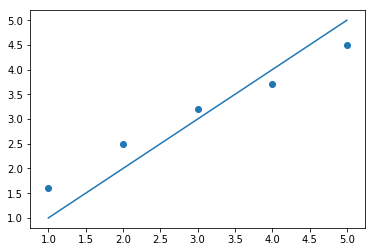

In [2]:
β = np.array([[1.0]]).T
X = np.array([[1.0, 2.0, 3.0, 4.0, 5.0]]).T
y = np.array([[1.6, 2.5, 3.2, 3.7, 4.5]]).T
plt.plot(X, X @ β)
plt.scatter(X, y)

##  Least square solution

We want to find the **optimal** parameters $\beta$ such that the squared deviations are minimized:

$$ \mathcal{L}_2 = |X \cdot \vec{\beta} - y|^2 $$

In [3]:
deviation = X @ β - y
L2 = np.sum(deviation**2)
NumpyToLatex(r"\left| X @ β - y \right|^2 = L2")

## Tensorflow Graph

Numeric calculations are expressed as a symbolic graph

In [4]:
import tensorflow as tf
β_symbol = tf.constant(β, name='beta')
X_symbol = tf.constant(X, name='X')
y_symbol = tf.constant(y, name='y')

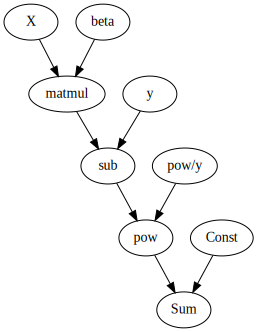

In [5]:
deviation_symbol = X_symbol @ β_symbol - y_symbol
L2_symbol = tf.reduce_sum(deviation_symbol**2)
TensorflowGraphToDot(L2_symbol)

## Tensorflow Session

A graph can be executed on different devices (CPUs, GPUs, Distributed, ...).
The tensorflow session can be configured accordingly.

In [6]:
session = tf.Session()

In [7]:
L2 = session.run(L2_symbol)
NumpyToLatex(r"\left| X @ β - y \right|^2 = L2")

## Automatic Differentiation

Tensorflow can automatically differentiate a graph with respect to one of its constituents and calculate gradients

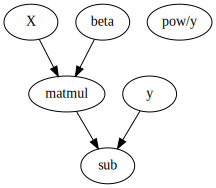

In [8]:
partial_derivative_symbol = tf.gradients(L2_symbol, β_symbol)
TensorflowGraphToDot(partial_derivative_symbol)

In [9]:
partial_derivative, = session.run(partial_derivative_symbol)
NumpyToLatex(r'\frac{\partial \mathcal{L}_2}{\partial \beta} = partial_derivative')

## Placeholders

Instead of assigning to each symbol explicit values, we can put in some placeholders.

In [10]:
β_symbol = tf.placeholder(dtype=tf.float64, shape=[1, None], name='beta')

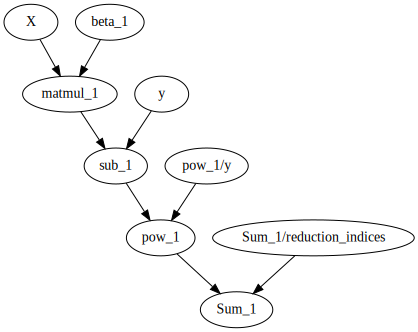

In [11]:
deviation_symbol = X_symbol @ β_symbol - y_symbol
L2_symbol = tf.reduce_sum(deviation_symbol**2, axis=0)
TensorflowGraphToDot(L2_symbol)

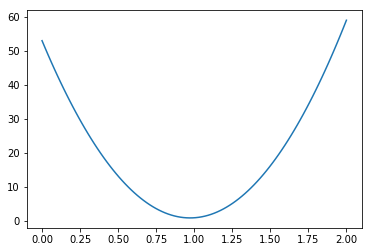

In [12]:
β = np.linspace(0.0, 2.0, 100).reshape((1,100))
L2 = session.run(L2_symbol, feed_dict={β_symbol: β})
plt.plot(β[0], L2)

In [13]:
"The optimal β is {:.2f}".format(β[0, L2.argmin()])

'The optimal β is 0.97'

## Gradient Descent

We can improve this by evaluating the $\mathcal{L}_2$ loss multiple times while adapting the parameters $\beta$.

$$ \beta_{n+1} = \beta_n - \eta \frac{\partial \mathcal{L}_2}{\partial \beta}$$

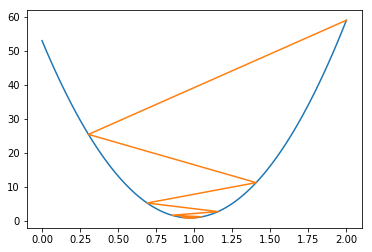

In [17]:
def gradient_descent(loss, parameters, beta, eta=0.015, N = 100):
    gradient = tf.gradients(loss, parameters)
    losses = []
    betas = []
    for n in range(N):
        l, g = session.run([loss, gradient], feed_dict={parameters: beta})
        losses.append(l)
        betas.append(beta)
        beta = beta - eta * g[0]
    return np.array(losses).flatten(), betas

losses, betas = gradient_descent(L2_symbol, β_symbol, np.array([[2.0]]))
plt.plot(β[0], L2)
plt.plot(np.array(betas).flatten(), losses)

## Linear Regression with Least Square in N-Dimension



In [44]:
import sklearn.datasets
X, y = sklearn.datasets.load_diabetes(True)
print(X.shape, y.shape)
# Add bias
X = np.c_[X, np.ones(442)]
y = y.reshape((442,1))
print(X.shape, y.shape)

(442, 10) (442,)
(442, 11) (442, 1)


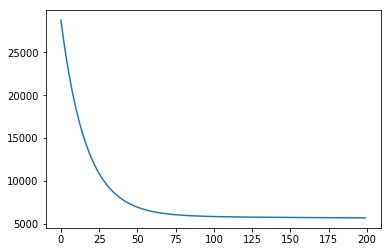

In [45]:
β_symbol = tf.placeholder(dtype=tf.float64, shape=[11, 1], name='beta')
X_symbol = tf.constant(X, name='X')
y_symbol = tf.constant(y, name='y')

deviation_symbol = X_symbol @ β_symbol - y_symbol
L2_symbol = tf.reduce_mean(deviation_symbol**2)

losses, betas = gradient_descent(L2_symbol, β_symbol, np.ones(11).reshape(11, 1).astype(float), N = 200)    
plt.plot(np.arange(200), losses)

## Tensorflow Variables and Optimizers

Of course tensorflow has already predefined optimizers (based on gradient descent), which are much more sophisticated.

In [52]:
def train(optimizer, loss, N = 200):
    init = tf.global_variables_initializer()
    session.run(init)
    losses = []
    for n in range(N):
        _, l = session.run([optimizer, loss])
        losses.append(l)
    return losses

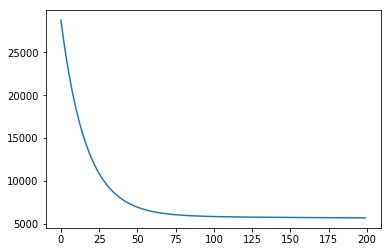

In [53]:
β_symbol = tf.Variable(np.ones(11).reshape((11,1)), name="beta")
loss = tf.losses.mean_squared_error(y_symbol, X_symbol @ β_symbol)
optimizer = tf.train.GradientDescentOptimizer(0.015).minimize(loss)

losses = train(optimizer, loss)
plt.plot(np.arange(200), losses)

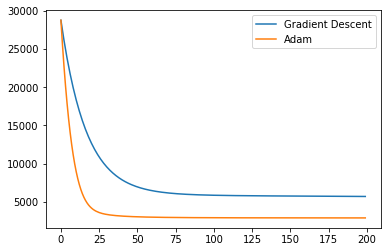

In [75]:
optimizer = tf.train.GradientDescentOptimizer(0.015).minimize(loss)
losses = train(optimizer, loss)
plt.plot(np.arange(200), losses, label='Gradient Descent')

optimizer = tf.train.AdamOptimizer(10, 0.01).minimize(loss)
losses = train(optimizer, loss)
plt.plot(np.arange(200), losses, label='Adam')
plt.legend()

## Framework Overview

<img src="https://www.tensorflow.org/images/tensorflow_programming_environment.png">

## Layers

In [83]:
dataset = tf.data.Dataset.from_tensor_slices(sklearn.datasets.load_diabetes(True))

In [84]:
dataset

<TensorSliceDataset shapes: ((10,), ()), types: (tf.float64, tf.float64)>

In [92]:
# Big problem, with this setup one cannot run the trained network on the complete dataset,
# or some test data, without defining the whole network again!

X, y = sklearn.datasets.load_diabetes(True)
X_train, y_train = X

dataset = tf.data.Dataset.from_tensor_slices((sklearn.datasets.load_diabetes(True)))
dataset = dataset.batch(10).repeat(100)
iterator = dataset.make_one_shot_iterator()
X, y = iterator.get_next()

hidden_layer1 = tf.layers.dense(X, 10, activation=tf.sigmoid)
hidden_layer2 = tf.layers.dense(hidden_layer1, 10, activation=tf.sigmoid)
output = tf.layers.dense(hidden_layer2, 1, activation=None)
prediction = tf.reshape(output, (-1,))

loss = tf.losses.mean_squared_error(y, prediction)
optimizer = tf.train.AdamOptimizer(10, 0.01).minimize(loss)

init = tf.global_variables_initializer()
session.run(init)

while True:
    try:
        value = session.run(optimizer)
    except tf.errors.OutOfRangeError:
        break

loss = session.run(loss)
print(loss)

ValueError: too many values to unpack (expected 2)